# Data Cleaning Notebook - Fluorinating Different GNPs

Load the necessary packages and modules.

In [40]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

sns.set_theme('paper',font_scale=1.5)
sns.set_style('white')

from modules.data_cleaning import clean_outliers, sample_spectra


## Import Data

Import the pickled data from (1).

In [41]:
data = pd.read_pickle(Path.cwd().joinpath('data','input','fluorination_different_gnps.pkl'))
data = data.fillna(0)
data = data.reset_index(drop=True) 

Extract details from the filename and peak fittings.

In [42]:
data['peaks']               = data.model.str.extractall(r"prefix=.([a-zA-Z0-9_]*)_").groupby(level=0)[0].apply(list)
data['material']            = data['file'].str.extract(r'^([a-zA-Z0-9-]*)_')
data['functionalisation']   = data['file'].str.extract(r'^[a-zA-Z0-9-]*_([a-zA-Z0-9]*)_')
data['map']                 = data['file'].str.extract(r'([0-9]).pkl').astype(int)

Find peak ratios.

In [43]:
data["Par_DG_IDG"]  = data["Par_D_height"]      / data["Par_G_height"]
data["Par_DG_ADG"]  = data["Par_D_amplitude"]   / data["Par_G_amplitude"]

data["Par_D2G_IDG"] = data["Par_D2_height"]     / data["Par_G_height"]
data["Par_D2G_ADG"] = data["Par_D2_amplitude"]  / data["Par_G_amplitude"]

data["Par_D2G_FDG"] = data["Par_D2_fwhm"]     / data["Par_G_fwhm"]
data["Par_DG_FDG"]  = data["Par_D_fwhm"]      / data["Par_G_fwhm"]

Read in x-axis data.

In [44]:
x = pd.read_csv(Path.cwd().joinpath('data','input','generic_x_fluorination.csv'), header=None)
x = x.to_numpy().reshape(len(x))

## Clean Data

Filter the dataframe to remove peak fitting issues. 
- D peak overfit
- D' peak replaces G peak

In [45]:
data_clean_1 = data.loc[data['Par_D_fwhm'].astype(float)< 130]
data_clean_1 = data_clean_1.loc[data_clean_1['Par_Dd_amplitude']<data_clean_1['Par_G_amplitude']]

data_clean_1.groupby(['material','functionalisation']).count()['spectrum']

material  functionalisation
C750      BL                   1793
          CF4                  1774
EC-GNP    BL                   1981
          CF4                  1984
HP-GNP    BL                   2030
          CF4                  2029
PG10      BL                   1954
          CF4                  1969
Name: spectrum, dtype: int64

Remove outliers 1.5x over/under the IQR.

In [46]:
data_clean_2 = clean_outliers(
    df_in               = data_clean_1,
    group_columns       =['material','functionalisation'],
    fit_features        = [
        'Par_DG_IDG',
        'Par_DG_ADG',
        'Par_D2G_IDG',
        'Par_D2G_ADG',
        'Par_DG_FDG',
        'Par_D2G_FDG',
        'Par_G_center',
        'Par_D2_center',
        'Par_D_center',
        ],
    extent_multiplier   = 1.5)

data_clean_2.groupby(['material','functionalisation']).count()['spectrum']

material  functionalisation
C750      BL                   1289
          CF4                  1273
EC-GNP    BL                   1309
          CF4                  1611
HP-GNP    BL                   1623
          CF4                  1461
PG10      BL                   1290
          CF4                  1171
Name: spectrum, dtype: int64

Make final number of spectra consistent (1000)

In [47]:
data_clean_2_sample = sample_spectra(
    data_clean_2,
    ['material','functionalisation'],
    1000
)

data_clean_2_sample.groupby(['material','functionalisation']).count()['spectrum']

material  functionalisation
C750      BL                   1000
          CF4                  1000
EC-GNP    BL                   1000
          CF4                  1000
HP-GNP    BL                   1000
          CF4                  1000
PG10      BL                   1000
          CF4                  1000
Name: spectrum, dtype: int64

## Plot

In [48]:
def average_group(group_in):
    
    item_sum = np.zeros(1011)
    k= 0 
    
    for item in group_in['data']:
        
        item_sum = item + item_sum
        k = k +1
    
    avg_spectrum = item_sum/k
    
    return avg_spectrum
        
avg_spectra = data_clean_2_sample.groupby(['material','functionalisation']).apply(average_group).reset_index()
avg_spectra.columns = ['material','functionalisation','spectra']


def expand_spectra(group_in):
    df = pd.DataFrame({
        'intensity': group_in['spectra'].iloc[0],
        'x':x,
        })
    
    return df

avg_spectra2 = avg_spectra.groupby(['material','functionalisation']).apply(expand_spectra).reset_index(drop=False)
avg_spectra2 = avg_spectra2[['material','functionalisation','intensity','x']]

def scale_spectra(group_in):
    
    group_in['intensity_scaled'] = group_in['intensity']/group_in['intensity'].max()
    return group_in

avg_spectra3 = avg_spectra2.groupby(['material','functionalisation']).apply(scale_spectra).reset_index(drop=False)

offset_dict ={'C750':1,
 'PG10':2,
 'EC-GNP':3,
 'HP-GNP':4}

def offset_spectra(group_in):
    group_in['intensity_offset'] = group_in['intensity_scaled'] + offset_dict[group_in['material'].iloc[0]]
    return group_in

avg_spectra4 = avg_spectra3.groupby(['material','functionalisation']).apply(offset_spectra).reset_index(drop=False)


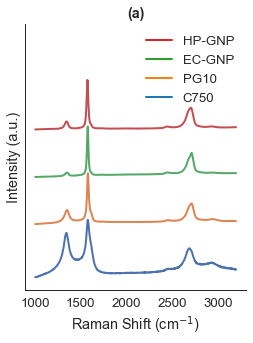

In [49]:
graph = sns.FacetGrid(
    data=avg_spectra4.loc[(avg_spectra4['x']>1000) & (avg_spectra4['x']<3200)],
    hue = 'material',
    hue_order = ['C750','PG10','EC-GNP','HP-GNP'],
    height = 5,
    aspect = 3/4
)

def graph_lineplot(*args, **kwargs):
    
    data = kwargs.pop('data')
    data_in = data.loc[data['functionalisation']=='BL']
    
    if args[0] == True:
        kwargs['color'] = 'tab:purple'
        data_in = data.loc[data['functionalisation']=='CF4']
        data_in['intensity_offset'] = data_in['intensity_offset'] + 0.5
    
    sns.lineplot(
        data = data_in,
        x = 'x',
        y = 'intensity_offset',
        **kwargs,
        lw=2,
    )


graph.map_dataframe(graph_lineplot, False)

custom_lines = [
    
    
    Line2D([0], [0], color='tab:red', lw=2,label='HP-GNP'),
    Line2D([0], [0], color='tab:green', lw=2,label = 'EC-GNP'),
    Line2D([0], [0], color='tab:orange', lw=2,label = 'PG10'),
    Line2D([0], [0], color='tab:blue', lw=2,label = 'C750'),
                ]

plt.legend(handles= custom_lines,frameon=False,loc='upper right')
plt.xlabel(r'Raman Shift (cm$^{-1}$)')
plt.ylabel(r'Intensity (a.u.)')
plt.title('(a)',fontweight='bold')
plt.yticks([])

plt.ylim(0.5,6.2)


plt.tight_layout()
plt.savefig(Path.cwd().joinpath('figures','Figure 6 (a).png'),dpi=300)
plt.show()

## Export Data

In [50]:
wide_data_export = data_clean_2_sample[[
    'material','map','functionalisation','spectrum',  
    'Par_G_height','Par_D_height','Par_D2_height',
    'Par_G_center','Par_G_fwhm','Par_G_amplitude',
    'Par_D_center','Par_D_fwhm','Par_D_amplitude',
    'Par_D2_center','Par_D2_fwhm','Par_D2_amplitude',
    'Par_DG_IDG','Par_DG_ADG',
    'Par_D2G_IDG','Par_D2G_ADG',
]].reset_index(drop=True)

In [51]:
wide_data_export.to_csv(
    Path.cwd().joinpath(
        'data',
        'output',
        'fluorination_different_gnps_cleaned.csv')
)